# (7) Signal (CPD) Search and Detection Criteria

In Part (6), we learned that any CPDs of interest in the SR 4 disk should be point sources (i.e., their size is $\ll$ the resolution) and could be pretty faint, perhaps comparable to the residuals from the circumstellar disk model.  We need to develop a means of quantifying what level of emission we are able to robustly detect.  One intuitive way for doing that is to inject a fake signal into the data, perform the same fitting/post-processing analysis we used on the real observations to get a residual dataset, and then try to recover the fake signal.  

For the last part, *recovery*, there is not a widely agreed-upon metric.  We'll have to develop our own approach and demonstrate that it works in practice.  Your goal in this part of the project is to establish an **automated** way to search for and quantify a point source in the SR 4 disk gap.  This machinery should (1) quantify the *significance* of any such feature (i.e., its signal-to-noise ratio, or the ratio of the peak to the "local" standard deviation); and (2) measure its flux; and (3) measure its position in the SR 4 disk gap (given how narrow the gap is, the radius should be just about 0.08", but the *azimuth* is unknown a priori).  There are no right or wrong answers here: your job is to experiment and see what might work.  Start simple...if we can make it work with a straightforward search in a (r,az)-map like before, let's do that!

I know this is sort of backwards, worrying about the recovery part before the injection part.  But I think it makes more sense in terms of the work that needs to be done.  The *injection* doesn't involve a lot of activity from a research perspective (its more of just a code machinery in a big loop).  I will show you how that works once your machinery is tested.  To help you develop, I've posted two example residual images online (see below) with mock CPDs already injected.  

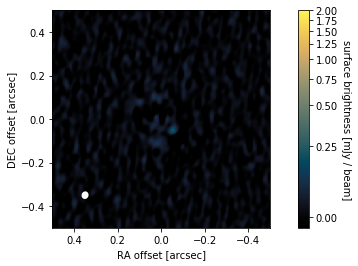

In [10]:
import os, sys, time
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import cmasher as cmr          
from astropy.visualization import (AsinhStretch, LogStretch, LinearStretch, ImageNormalize)
from matplotlib.patches import Ellipse    

# residuals - imaged like in DSHARP I, II
data = fits.open('SR4_residtest.fits')
dimage = np.squeeze(data[0].data)
dheader = data[0].header

# coordinates
nx, ny = dheader['NAXIS1'], dheader['NAXIS2']
RA = dheader['CRVAL1'] + dheader['CDELT1'] * (np.arange(nx) - (dheader['CRPIX1'] - 1))
DEC = dheader['CRVAL2'] + dheader['CDELT2'] * (np.arange(ny) - (dheader['CRPIX2'] - 1))
RAo, DECo = 3600 * (RA - dheader['CRVAL1']), 3600 * (DEC - dheader['CRVAL2'])
offRA, offDEC = -0.060, -0.509
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC
dRA, dDEC = np.meshgrid(RAo_shift, DECo_shift)
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())

# now set the RA and DEC offset ranges you want to show
dRA_lims  = [0.5, -0.5]      # (same reverse ordering to ensure E is to the left)
dDEC_lims = [-0.5, 0.5]


# now define the color-map, intensity limits, and stretch
cmap = cmr.eclipse
vmin, vmax = -0.03, 2.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(1e3*dimage, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
dbeam_maj, dbeam_min, dbeam_PA = 3600 * dheader['BMAJ'], 3600 * dheader['BMIN'], dheader['BPA']
dbeam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                 dbeam_maj, dbeam_min, 90-dbeam_PA)
dbeam.set_facecolor('w')
ax.add_artist(dbeam)

In [11]:
from scipy.interpolate import interp1d

# inclination and PA
incl, PA = 22., 26.

# convert these to radius
inclr, PAr = np.radians(incl), np.radians(PA)

# deproject and rotate to new coordinate frame
xp = (dRA * np.cos(PAr) - dDEC * np.sin(PAr)) / np.cos(inclr)
yp = (dRA * np.sin(PAr) + dDEC * np.cos(PAr))

# now convert to polar coordinates (r in arcseconds, theta in degrees)
# note that theta starts along the minor axis (theta = 0), and rotates clockwise in the sky plane)
r = np.sqrt(xp**2 + yp**2)
theta = np.degrees(np.arctan2(yp, xp))

# radius and azimuth bin centers (and their widths)
#rbins = np.linspace(0.003, 0.6, 300)    # in arcseconds
rbins = np.arange(0.003, 0.6, 0.003)
tbins = np.linspace(-180, 180, 181)     # in degrees

def razmap(imarray, rbins, tbins):

    # bin widths
    dr = np.abs(rbins[1] - rbins[0])
    dt = np.abs(tbins[1] - tbins[0])
    
    # initialize the (r, az)-map and radial profile
    rtmap = np.empty((len(tbins), len(rbins)))
    SBr, err_SBr = np.empty(len(rbins)), np.empty(len(rbins))

    # loop through the bins to populate the (r, az)-map and radial profile
    for i in range(len(rbins)):
        # identify pixels that correspond to the radial bin (i.e., in this annulus)
        in_annulus = ((r >= (rbins[i] - 0.5 * dr)) & (r < (rbins[i] + 0.5 * dr)))
    
        # accumulate the azimuth values and surface brightness values in this annulus
        az_annulus = theta[in_annulus]
        SB_annulus = imarray[in_annulus]
    
        # average the intensities (and their scatter) in the annulus
        SBr[i], err_SBr[i] = np.average(SB_annulus), np.std(SB_annulus)
    
        # populate the azimuthal bins for the (r, az)-map at this radius
        for j in range(len(tbins)):
            # identify pixels that correspond to the azimuthal bin
            in_wedge = ((az_annulus >= (tbins[j] - 0.5 * dt)) & (az_annulus < (tbins[j] + 0.5 * dt)))
        
            # if there are pixels in that bin, average the corresponding intensities
            if (len(SB_annulus[in_wedge]) > 0):
                rtmap[j,i] = np.average(SB_annulus[in_wedge])
            else:
                rtmap[j,i] = -1e10    # this is a temporary placeholder; it will be fixed in next piece of code
            
    # now "fix" the (r, az)-map where there are too few pixels in certain az bins (inner disk)
    # its ok if this part is a "black box": it is not important / relevant
    for i in range(len(rbins)):
        # extract an azimuthal slice of the (r, az)-map
        az_slice = rtmap[:,i]
    
        # identify if there's missing information in an az bin along that slice:
        # if so, fill it in with linear interpolation along the slice
        if np.any(az_slice < -1e5):
            # extract non-problematic bins in the slice
            x_slice, y_slice = tbins[az_slice >= -1e5], az_slice[az_slice >= -1e5]
        
            # pad the arrays to make sure they span a full circle in azimuth
            x_slice_ext = np.pad(x_slice, 1, mode='wrap')
            x_slice_ext[0] -= 360.
            x_slice_ext[-1] += 360.
            y_slice_ext = np.pad(y_slice, 1, mode='wrap')
        
            # define the interpolation function
            raz_func = interp1d(x_slice_ext, y_slice_ext, bounds_error=True)
        
            # interpolate and replace those bins in the (r, az)-map
            fixed_slice = raz_func(tbins)
            rtmap[:,i] = fixed_slice
        
    class raz_out:
        def __init__(self, razmap, r, az, prof, eprof):
            self.razmap = razmap
            self.r = r
            self.az = az
            self.prof = prof
            self.eprof = eprof
            
    return raz_out(rtmap, rbins, tbins, SBr, err_SBr)

In [12]:
deproj_d = razmap(dimage, rbins, tbins)

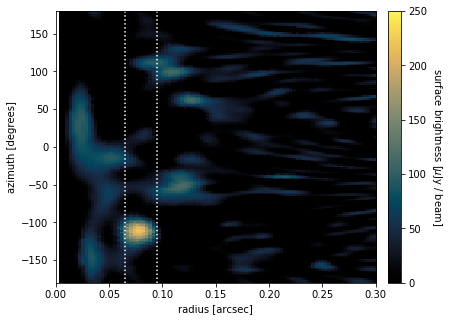

In [13]:
# temp
raz_d = deproj_d.razmap

# define the full (r, az)-map boundaries with a list of the min/max (r, az) bins
rtmap_bounds = (rbins.min(), rbins.max(), tbins.min(), tbins.max())

# set the radius and azimuth ranges you want to show
t_lims = [-180, 180]      
r_lims = [0, 0.3]

# now define the color-map, intensity limits, and stretch
cmap = cmr.eclipse
vmin, vmax = 0, 250    
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())

# set up and plot the images on the specified scale
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(1e6*raz_d, origin='lower', cmap=cmap, extent=rtmap_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(t_lims)
ax.plot([0.065, 0.065], [-180, 180], ':w')
ax.plot([0.095, 0.095], [-180, 180], ':w')
ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.03)
cb.set_label('surface brightness [$\mu$Jy / beam]', rotation=270, labelpad=17)

In [14]:
# isolate the emission in the gap region (+/-15 mas from mean gap radius of 80 mas)
r_wedge = ((rbins >= 0.065) & (rbins <= 0.095))
raz_gap = raz_d[:, r_wedge]
rbins_gap = rbins[r_wedge]
print(raz_gap.shape)

# find the peak
tpeak_idx, rpeak_idx = np.unravel_index(np.argsort(raz_gap, axis=None), raz_gap.shape)
az_peak, r_peak = tbins[tpeak_idx[-1]], rbins_gap[rpeak_idx[-1]]

# peak brightness
f_cpd = raz_gap[tpeak_idx[-1], rpeak_idx[-1]]

print(1e6*f_cpd, az_peak, r_peak)

# local significance of peak

# make a 2-D mask
mask = np.zeros_like(raz_gap, dtype='bool')
az_wid = 15.
t_exc = ((tbins >= (az_peak - az_wid)) & (tbins <= (az_peak + az_wid)))
mask[t_exc, :] = True

# calculate noise outside the masked region
noise_gap = np.std(raz_gap[~mask])

# SNR of the peak
print(noise_gap)
print(f_cpd / noise_gap)

(181, 10)
222.71156194619834 -112.0 0.07500000000000001
3.7021099668876414e-05
6.0158008254258215
